In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn.init import _calculate_fan_in_and_fan_out
from einops import rearrange
import math
import warnings
import cv2
import numpy as np
import os
import shutil
import hdf5storage
import itertools
from glob import glob

# ================= CONFIGURATION =================
# Path for existing RGB dataset
RGB_DATASET_PATH = "/home/shasvat/NAS/data/potato-dataset"

# Path where HSI data will be saved
HSI_OUTPUT_PATH = "/home/shasvat/NAS/data/potato-hsi-dataset"

# Path for pre-trained MST++ model file (.pth)
MODEL_PATH = "/home/shasvat/mtp/mst_plus_plus/rgb_to_hsi/best_model/mst_plus_plus.pth" 

# GPU Configuration
GPU_ID = '0'
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")


Running on device: cuda


In [ ]:
# ================= HELPER FUNCTIONS =================
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_.", stacklevel=2)
    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

class GELU(nn.Module):
    def forward(self, x):
        return F.gelu(x)

class MS_MSA(nn.Module):
    def __init__(self, dim, dim_head, heads):
        super().__init__()
        self.num_heads = heads
        self.dim_head = dim_head
        self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
        self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
        self.proj = nn.Linear(dim_head * heads, dim, bias=True)
        self.pos_emb = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
            GELU(),
            nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim),
        )
        self.dim = dim

    def forward(self, x_in):
        b, h, w, c = x_in.shape
        x = x_in.reshape(b,h*w,c)
        q_inp = self.to_q(x)
        k_inp = self.to_k(x)
        v_inp = self.to_v(x)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), (q_inp, k_inp, v_inp))
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)
        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)
        attn = (k @ q.transpose(-2, -1))
        attn = attn * self.rescale
        attn = attn.softmax(dim=-1)
        x = attn @ v
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(b, h * w, self.num_heads * self.dim_head)
        out_c = self.proj(x).view(b, h, w, c)
        out_p = self.pos_emb(v_inp.reshape(b,h,w,c).permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        return out_c + out_p

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1, 1, bias=False),
            GELU(),
            nn.Conv2d(dim * mult, dim * mult, 3, 1, 1, bias=False, groups=dim * mult),
            GELU(),
            nn.Conv2d(dim * mult, dim, 1, 1, bias=False),
        )
    def forward(self, x):
        out = self.net(x.permute(0, 3, 1, 2))
        return out.permute(0, 2, 3, 1)

class MSAB(nn.Module):
    def __init__(self, dim, dim_head, heads, num_blocks):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_blocks):
            self.blocks.append(nn.ModuleList([
                MS_MSA(dim=dim, dim_head=dim_head, heads=heads),
                PreNorm(dim, FeedForward(dim=dim))
            ]))
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        for (attn, ff) in self.blocks:
            x = attn(x) + x
            x = ff(x) + x
        out = x.permute(0, 3, 1, 2)
        return out

class MST(nn.Module):
    def __init__(self, in_dim=31, out_dim=31, dim=31, stage=2, num_blocks=[2,4,4]):
        super(MST, self).__init__()
        self.dim = dim
        self.stage = stage
        self.embedding = nn.Conv2d(in_dim, self.dim, 3, 1, 1, bias=False)
        self.encoder_layers = nn.ModuleList([])
        dim_stage = dim
        for i in range(stage):
            self.encoder_layers.append(nn.ModuleList([
                MSAB(dim=dim_stage, num_blocks=num_blocks[i], dim_head=dim, heads=dim_stage // dim),
                nn.Conv2d(dim_stage, dim_stage * 2, 4, 2, 1, bias=False),
            ]))
            dim_stage *= 2
        self.bottleneck = MSAB(dim=dim_stage, dim_head=dim, heads=dim_stage // dim, num_blocks=num_blocks[-1])
        self.decoder_layers = nn.ModuleList([])
        for i in range(stage):
            self.decoder_layers.append(nn.ModuleList([
                nn.ConvTranspose2d(dim_stage, dim_stage // 2, stride=2, kernel_size=2, padding=0, output_padding=0),
                nn.Conv2d(dim_stage, dim_stage // 2, 1, 1, bias=False),
                MSAB(dim=dim_stage // 2, num_blocks=num_blocks[stage - 1 - i], dim_head=dim, heads=(dim_stage // 2) // dim),
            ]))
            dim_stage //= 2
        self.mapping = nn.Conv2d(self.dim, out_dim, 3, 1, 1, bias=False)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        fea = self.embedding(x)
        fea_encoder = []
        for (MSAB, FeaDownSample) in self.encoder_layers:
            fea = MSAB(fea)
            fea_encoder.append(fea)
            fea = FeaDownSample(fea)
        fea = self.bottleneck(fea)
        for i, (FeaUpSample, Fution, LeWinBlcok) in enumerate(self.decoder_layers):
            fea = FeaUpSample(fea)
            fea = Fution(torch.cat([fea, fea_encoder[self.stage-1-i]], dim=1))
            fea = LeWinBlcok(fea)
        out = self.mapping(fea) + x
        return out

class MST_Plus_Plus(nn.Module):
    def __init__(self, in_channels=3, out_channels=31, n_feat=31, stage=3):
        super(MST_Plus_Plus, self).__init__()
        self.stage = stage
        self.conv_in = nn.Conv2d(in_channels, n_feat, kernel_size=3, padding=(3 - 1) // 2,bias=False)
        modules_body = [MST(dim=31, stage=2, num_blocks=[1,1,1]) for _ in range(stage)]
        self.body = nn.Sequential(*modules_body)
        self.conv_out = nn.Conv2d(n_feat, out_channels, kernel_size=3, padding=(3 - 1) // 2,bias=False)

    def forward(self, x):
        b, c, h_inp, w_inp = x.shape
        hb, wb = 8, 8
        pad_h = (hb - h_inp % hb) % hb
        pad_w = (wb - w_inp % wb) % wb
        x = F.pad(x, [0, pad_w, 0, pad_h], mode='reflect')
        x = self.conv_in(x)
        h = self.body(x)
        h = self.conv_out(h)
        h += x
        return h[:, :, :h_inp, :w_inp]

# Initialize Model
model = MST_Plus_Plus().to(device)

# Load Pretrained Weights
if os.path.exists(MODEL_PATH):
    print(f"Loading model from {MODEL_PATH}...")
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict({k.replace('module.', ''): v for k, v in checkpoint['state_dict'].items()}, strict=True)
    model.eval() # Set to eval mode
else:
    print(f"ERROR: Model file not found at {MODEL_PATH}")


Loading model from /home/shasvat/mtp/mst_plus_plus/rgb_to_hsi/best_model/mst_plus_plus.pth...


/tmp/ipykernel_1267820/3843885357.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH)


In [5]:
def save_matv73(mat_name, var_name, var):
    """Saves data to a .mat file compatible with MATLAB v7.3"""
    hdf5storage.savemat(mat_name, {var_name: var}, format='7.3', store_python_metadata=True)

def forward_ensemble(x, forward_func, ensemble_mode='mean'):
    """Performs ensemble inference (flips/rotations) for better quality"""
    def _transform(data, xflip, yflip, transpose, reverse=False):
        if not reverse:  # forward transform
            if xflip: data = torch.flip(data, [3])
            if yflip: data = torch.flip(data, [2])
            if transpose: data = torch.transpose(data, 2, 3)
        else:  # reverse transform
            if transpose: data = torch.transpose(data, 2, 3)
            if yflip: data = torch.flip(data, [2])
            if xflip: data = torch.flip(data, [3])
        return data

    outputs = []
    opts = itertools.product((False, True), (False, True), (False, True))
    for xflip, yflip, transpose in opts:
        data = x.clone()
        data = _transform(data, xflip, yflip, transpose)
        data = forward_func(data)
        outputs.append(_transform(data, xflip, yflip, transpose, reverse=True))
    
    if ensemble_mode == 'mean':
        return torch.stack(outputs, 0).mean(0)
    elif ensemble_mode == 'median':
        return torch.stack(outputs, 0).median(0)[0]


In [ ]:
subfolders = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]

cudnn.benchmark = True
print("Starting HSI Generation Pipeline...")

for folder in subfolders:
    input_folder = os.path.join(RGB_DATASET_PATH, folder)
    output_folder = os.path.join(HSI_OUTPUT_PATH, folder)
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created folder: {output_folder}")
    

    images = glob(os.path.join(input_folder, "*.JPG")) + glob(os.path.join(input_folder, "*.jpg"))
    print(f"\nProcessing {folder}: Found {len(images)} images.")
    
    for img_path in images:
        filename = os.path.basename(img_path)
        base_name = os.path.splitext(filename)[0]
        
        # --- 1. Inference (RGB -> HSI) ---
        try:
            # Load & Preprocess
            bgr = cv2.imread(img_path)
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            rgb = np.float32(rgb)
            # Normalize to [0, 1]
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
            # [H, W, C] -> [C, H, W] -> [1, C, H, W]
            rgb_tensor = np.expand_dims(np.transpose(rgb, [2, 0, 1]), axis=0).copy()
            rgb_tensor = torch.from_numpy(rgb_tensor).float().to(device)
            
            # Run Model
            with torch.no_grad():
                result = forward_ensemble(rgb_tensor, model, ensemble_mode='mean')
            
            # Post-process
            result = result.cpu().numpy() * 1.0
            # [C, H, W] -> [H, W, C]
            result = np.transpose(np.squeeze(result), [1, 2, 0])
            result = np.minimum(result, 1.0)
            result = np.maximum(result, 0)
            
            # Save .mat file
            mat_save_path = os.path.join(output_folder, base_name + ".mat")
            save_matv73(mat_save_path, 'cube', result)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

        # --- 2. Copy Label File (.txt) ---
        txt_filename = base_name + ".txt"
        src_txt_path = os.path.join(input_folder, txt_filename)
        dst_txt_path = os.path.join(output_folder, txt_filename)
        
        if os.path.exists(src_txt_path):
            shutil.copy(src_txt_path, dst_txt_path)
        else:
            pass
            
    print(f"Completed folder: {folder}")

print("\n All Done! HSI Dataset generated at:", HSI_OUTPUT_PATH)


🚀 Starting HSI Generation Pipeline...
Created folder: /home/shasvat/NAS/data/potato-hsi-dataset/Potato___Early_blight

Processing Potato___Early_blight: Found 1939 images.
✅ Completed folder: Potato___Early_blight
Created folder: /home/shasvat/NAS/data/potato-hsi-dataset/Potato___Late_blight

Processing Potato___Late_blight: Found 1939 images.
✅ Completed folder: Potato___Late_blight
Created folder: /home/shasvat/NAS/data/potato-hsi-dataset/Potato___healthy

Processing Potato___healthy: Found 1824 images.
✅ Completed folder: Potato___healthy

🎉 All Done! HSI Dataset generated at: /home/shasvat/NAS/data/potato-hsi-dataset


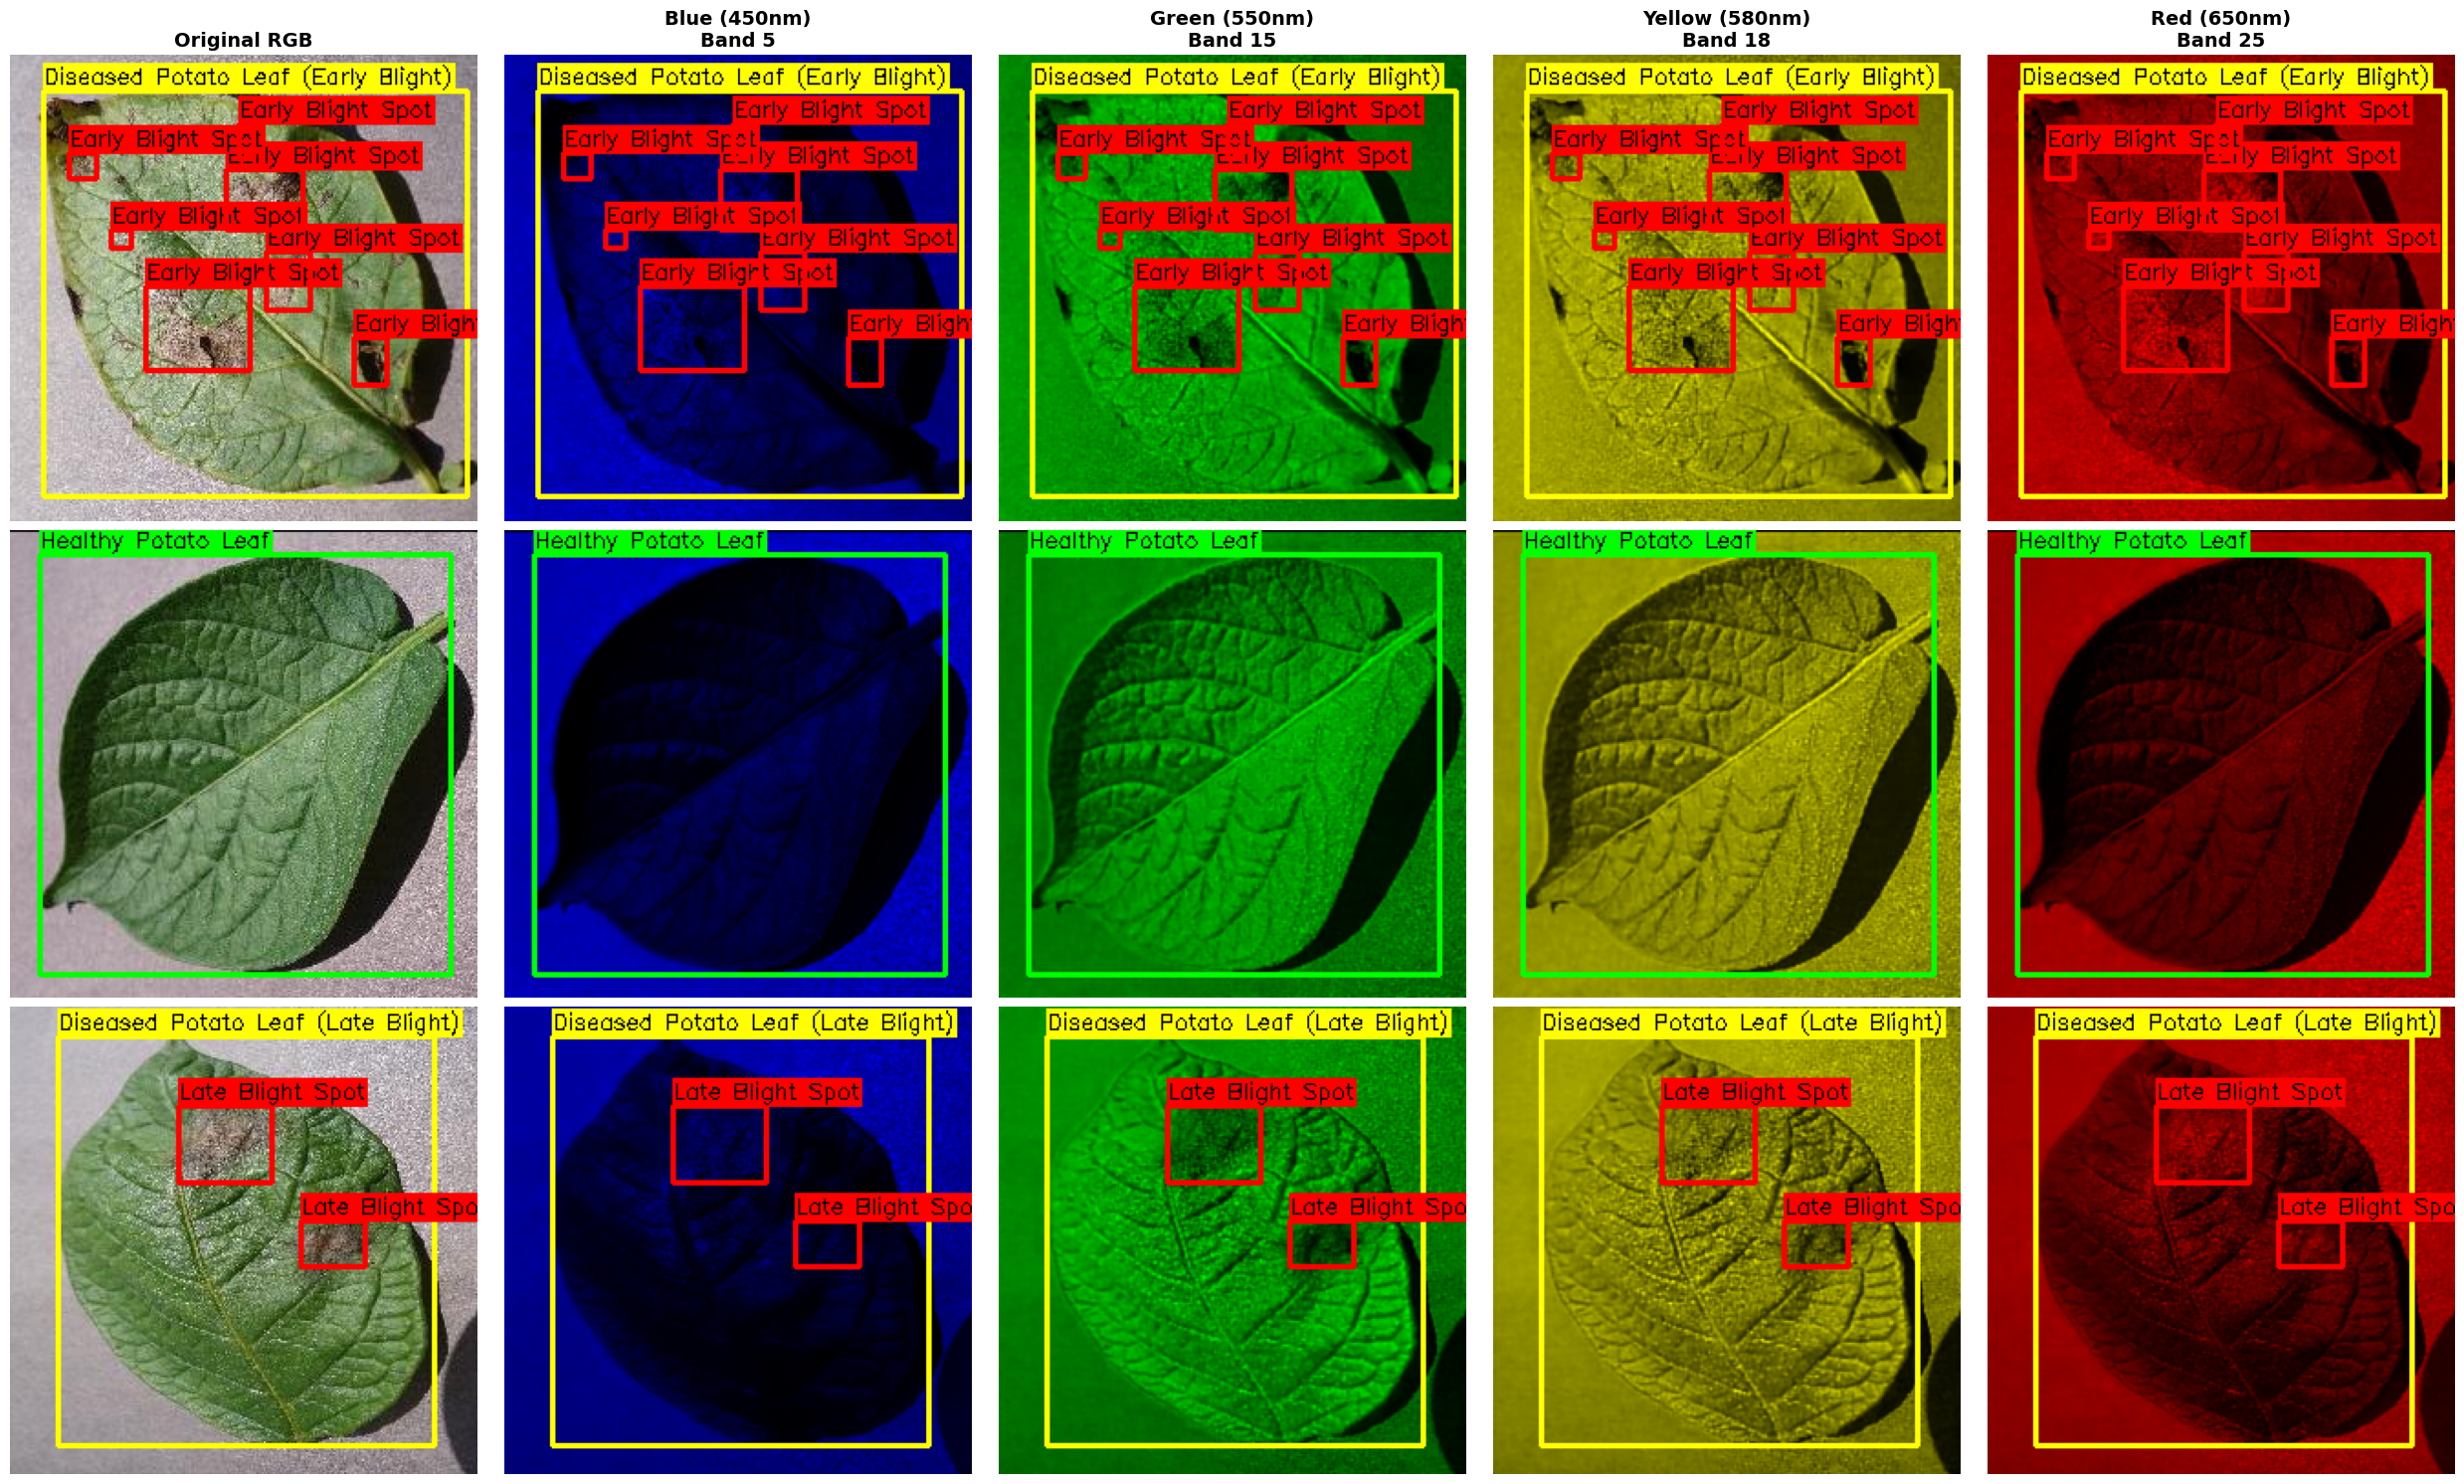

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2

# ================= CONFIGURATION =================
HSI_DATASET_PATH = "/home/shasvat/NAS/data/potato-hsi-dataset"
RGB_DATASET_PATH = "/home/shasvat/NAS/data/potato-dataset"

TARGET_FILES = [
    ("Potato___Early_blight", "0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG"),
    ("Potato___healthy",      "0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817_90deg.JPG"),
    ("Potato___Late_blight",  "0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG")
]

# Define Bands and their display colors (Hex codes)
WAVELENGTH_BANDS = [
    ("Blue (450nm)",   5,  "#0000FF"), # Pure Blue
    ("Green (550nm)",  15, "#00FF00"), # Pure Green
    ("Yellow (580nm)", 18, "#FFFF00"), # Yellow
    ("Red (650nm)",    25, "#FF0000")  # Pure Red
]

LABEL_MAP = {
    0: "Healthy Potato Leaf",
    1: "Diseased Potato Leaf (Early Blight)",
    2: "Diseased Potato Leaf (Late Blight)",
    3: "Early Blight Spot",
    4: "Late Blight Spot"
}

# ================= HELPER FUNCTIONS =================

def create_mono_cmap(color_hex):
    """Creates a colormap from Black -> Color"""
    rgb = mcolors.hex2color(color_hex)
    return mcolors.LinearSegmentedColormap.from_list(f"mono_{color_hex}", ["black", color_hex], N=256)

def apply_cmap_to_image(img_gray, cmap):
    """Applies a matplotlib colormap to a grayscale numpy image and returns RGB numpy array"""
    # Normalize 0-1
    norm_img = img_gray.astype(float) / 255.0
    # Apply colormap (returns RGBA)
    rgba_img = cmap(norm_img)
    # Convert to RGB (0-255)
    rgb_img = (rgba_img[:, :, :3] * 255).astype(np.uint8)
    return rgb_img

def load_hsi_mat(mat_path):
    try:
        with h5py.File(mat_path, 'r') as f:
            cube = f['cube'][:]
        if cube.shape[0] == 31 and cube.shape[1] > 31:
             cube = np.transpose(cube, (1, 2, 0))
        return cube
    except Exception as e:
        print(f"Error loading {mat_path}: {e}")
        return None

def load_annotations(txt_path, h, w):
    boxes = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                cls_id = int(parts[0])
                cx, cy, bw, bh = map(float, parts[1:])
                x1, y1, x2, y2 = int((cx-bw/2)*w), int((cy-bh/2)*h), int((cx+bw/2)*w), int((cy+bh/2)*h)
                boxes.append((cls_id, x1, y1, x2, y2))
    return boxes

def draw_boxes(img_rgb, boxes):
    """Draws boxes on an already colored (RGB) image"""
    img_vis = img_rgb.copy()
    
    for cls_id, x1, y1, x2, y2 in boxes:
        if cls_id == 0: color = (0, 255, 0) # Green
        elif cls_id in [1, 2]: color = (255, 255, 0) # Yellow
        else: color = (255, 0, 0) # Red

        label = LABEL_MAP.get(cls_id, "Unknown")
        
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), color, 2)
        
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        cv2.rectangle(img_vis, (x1, y1 - 15), (x1 + w, y1), color, -1)
        cv2.putText(img_vis, label, (x1, y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
        
    return img_vis

# ================= MAIN LOOP =================

plt.figure(figsize=(25, 15))
plot_idx = 1
total_columns = len(WAVELENGTH_BANDS) + 1

for folder, filename in TARGET_FILES:
    mat_filename = filename.replace(".JPG", ".mat").replace(".jpg", ".mat")
    txt_filename = filename.replace(".JPG", ".txt").replace(".jpg", ".txt")
    
    mat_path = os.path.join(HSI_DATASET_PATH, folder, mat_filename)
    txt_path = os.path.join(HSI_DATASET_PATH, folder, txt_filename)
    rgb_path = os.path.join(RGB_DATASET_PATH, folder, filename)
    
    if not os.path.exists(mat_path):
        plot_idx += total_columns
        continue

    hsi_cube = load_hsi_mat(mat_path)
    if hsi_cube is None:
        plot_idx += total_columns
        continue

    # Rotation Fix
    rgb_img = None
    if os.path.exists(rgb_path):
        rgb_img = cv2.imread(rgb_path)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        h_rgb, w_rgb = rgb_img.shape[:2]
        h_hsi, w_hsi = hsi_cube.shape[:2]
        if (h_rgb == w_hsi) and (w_rgb == h_hsi):
            hsi_cube = np.transpose(hsi_cube, (1, 0, 2))
    
    H, W, C = hsi_cube.shape
    boxes = load_annotations(txt_path, H, W)

    # 1. RGB PLOT
    plt.subplot(3, total_columns, plot_idx)
    if rgb_img is not None:
        rgb_annotated = draw_boxes(rgb_img, boxes)
        plt.imshow(rgb_annotated)
    else:
        plt.text(0.5, 0.5, "RGB Missing", ha='center')
    plt.axis("off")
    if plot_idx <= total_columns: plt.title("Original RGB", fontsize=14, fontweight='bold')
    if plot_idx % total_columns == 1: plt.ylabel(folder.replace("Potato___", ""), fontsize=14, fontweight='bold')
    plot_idx += 1

    # 2. SPECTRAL BANDS (COLORIZED)
    for band_name, band_idx, color_hex in WAVELENGTH_BANDS:
        # Get Band
        band_data = hsi_cube[:, :, band_idx]
        band_gray = cv2.normalize(band_data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Colorize
        cmap = create_mono_cmap(color_hex)
        band_colored = apply_cmap_to_image(band_gray, cmap)
        
        # Annotate
        final_img = draw_boxes(band_colored, boxes)
        
        plt.subplot(3, total_columns, plot_idx)
        plt.imshow(final_img)
        plt.axis("off")
        if plot_idx <= total_columns: plt.title(f"{band_name}\nBand {band_idx}", fontsize=14, fontweight='bold')
        plot_idx += 1

plt.tight_layout()
plt.show()


Processing: 0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817_90deg.JPG
🔄 Fixing rotation...


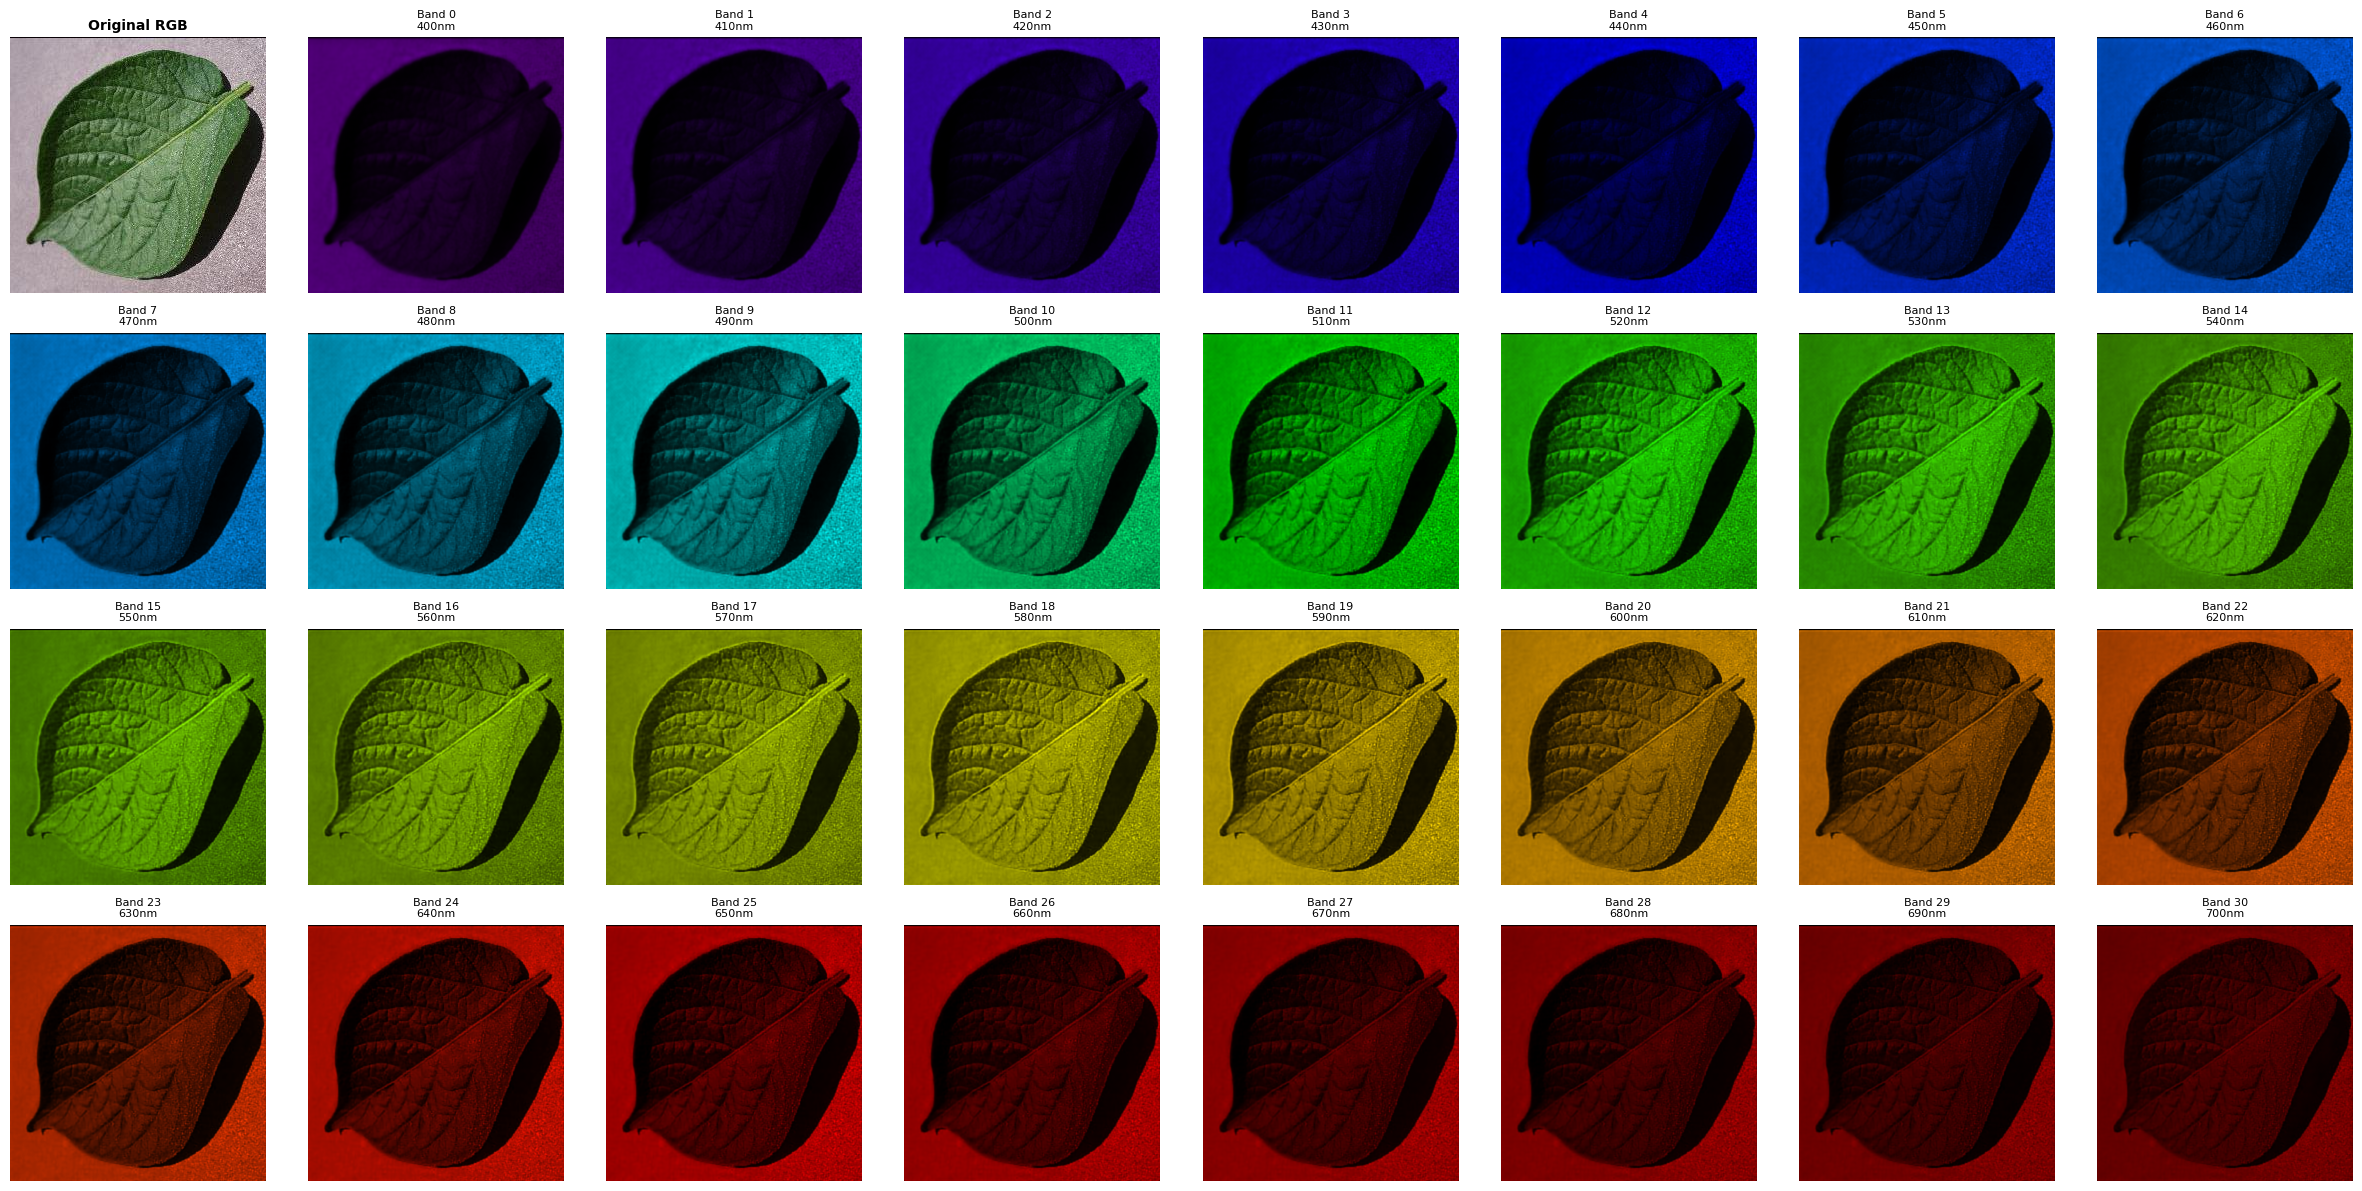

In [7]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2

# ================= CONFIGURATION =================
HSI_DATASET_PATH = "/home/shasvat/NAS/data/potato-hsi-dataset"
RGB_DATASET_PATH = "/home/shasvat/NAS/data/potato-dataset"

# Specific Healthy Leaf File
FOLDER = "Potato___healthy"
FILENAME = "0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817_90deg.JPG"

# ================= HELPER FUNCTIONS =================

def wavelength_to_rgb(wavelength, gamma=0.8):
    '''This converts a given wavelength of light to an approximate RGB color value.'''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = (-(wavelength - 440) / (440 - 380)) * attenuation
        G = 0.0
        B = 1.0 * attenuation
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif wavelength >= 510 and wavelength <= 580:
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = 1.0 * attenuation
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R, G, B)

def create_spectral_cmap(wavelength):
    """Creates a colormap from Black -> Spectral Color of that wavelength"""
    color_rgb = wavelength_to_rgb(wavelength)
    return mcolors.LinearSegmentedColormap.from_list(f"wl_{wavelength}", [(0,0,0), color_rgb], N=256)

def apply_cmap(img_gray, cmap):
    norm_img = img_gray.astype(float) / 255.0
    rgba_img = cmap(norm_img)
    return (rgba_img[:, :, :3] * 255).astype(np.uint8)

def load_hsi_mat(mat_path):
    try:
        with h5py.File(mat_path, 'r') as f:
            cube = f['cube'][:]
        if cube.shape[0] == 31 and cube.shape[1] > 31:
             cube = np.transpose(cube, (1, 2, 0))
        return cube
    except Exception as e:
        print(f"Error: {e}")
        return None

# ================= MAIN EXECUTION =================

# Paths
mat_filename = FILENAME.replace(".JPG", ".mat").replace(".jpg", ".mat")
mat_path = os.path.join(HSI_DATASET_PATH, FOLDER, mat_filename)
rgb_path = os.path.join(RGB_DATASET_PATH, FOLDER, FILENAME)

print(f"Processing: {FILENAME}")

# 1. Load Data
hsi_cube = load_hsi_mat(mat_path)
rgb_img = cv2.imread(rgb_path)
rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

if hsi_cube is None or rgb_img is None:
    print("Error loading files.")
else:
    # 2. Fix Rotation
    h_rgb, w_rgb = rgb_img.shape[:2]
    h_hsi, w_hsi = hsi_cube.shape[:2]
    if (h_rgb == w_hsi) and (w_rgb == h_hsi):
        print("🔄 Fixing rotation...")
        hsi_cube = np.transpose(hsi_cube, (1, 0, 2))

    # 3. Visualization Grid
    # Total 32 plots: 1 RGB + 31 Bands
    rows = 4
    cols = 8
    plt.figure(figsize=(24, 12))

    # --- PLOT 1: RGB ---
    plt.subplot(rows, cols, 1)
    plt.imshow(rgb_img)
    plt.title("Original RGB", fontsize=10, fontweight='bold')
    plt.axis("off")

    # --- PLOT 2-32: BANDS ---
    # Wavelength range: 400nm to 700nm across 31 bands
    # Step size approx 10nm
    start_wl = 400
    step_wl = 10
    
    for i in range(31):
        wavelength = start_wl + (i * step_wl)
        
        # Get Band Data
        band_img = hsi_cube[:, :, i]
        band_gray = cv2.normalize(band_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Colorize based on physical wavelength color
        cmap = create_spectral_cmap(wavelength)
        band_color = apply_cmap(band_gray, cmap)
        
        # Plot (Index starts at 2 because 1 is RGB)
        plt.subplot(rows, cols, i + 2)
        plt.imshow(band_color)
        plt.title(f"Band {i}\n{wavelength}nm", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
